In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []
_, _ = env.reset()

for _ in range(200):
    frames.append(env.render())
    action = env.action_space.sample()
    _, _, done, _, _ = env.step(action)
    if done:
        break
env.close()

fig = plt.figure()
plt.axis('off')
ims = [[plt.imshow(frame)] for frame in frames]
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
plt.close()
HTML(ani.to_jshtml())

In [3]:
# 2.3b

In [4]:
def policy1(observation):
    # Only use angle
    return 0 if observation[2] < 0 else 1

In [5]:
def evaluate_policy(policy, episodes=200):
    env = gym.make("CartPole-v1")
    rewards = []
    for _ in range(episodes):
        observation, _ = env.reset()
        total_reward = 0
        for _ in range(200):
            action = policy(observation)
            observation, reward, done, _, _ = env.step(action)
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    env.close()
    return rewards

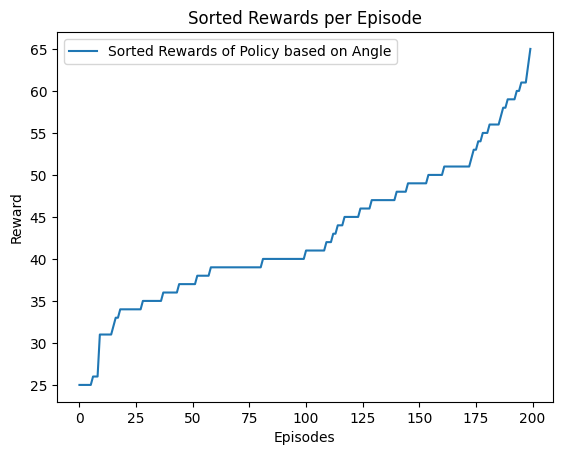

In [6]:
rewards = sorted(evaluate_policy(policy1))
plt.plot(rewards, label="Sorted Rewards of Policy based on Angle")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.title("Sorted Rewards per Episode")
plt.show()

In [7]:
def policy2(observation):
    angle = observation[2]
    angular_velocity = observation[3]
    
    if angle < 0 and angular_velocity < 0:
        return 0 # Definitly adjust to left
    elif angle > 0 and angular_velocity > 0:
        return 1 # Adjust to right
    else:
        return 0 if angle < 0 else 1
# Only as before

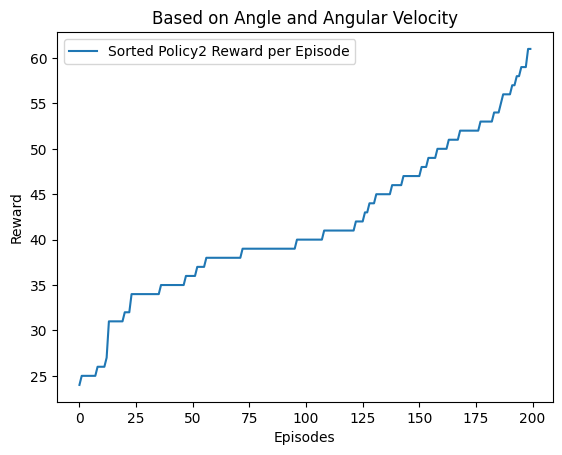

In [8]:
rewards = sorted(evaluate_policy(policy2))
plt.plot(rewards, label="Sorted Policy2 Reward per Episode")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.title("Based on Angle and Angular Velocity")
plt.show()

In [9]:
# Task 2.3c

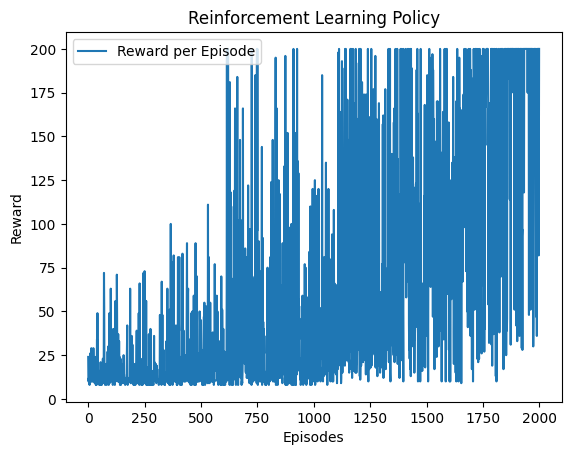

In [13]:
class DiscretizeObservation(gym.ObservationWrapper):
    def __init__(self, env, bins=(6, 6, 12, 12)):
        super().__init__(env)
        self.env = env
        self.bins = bins
        self.observation_space = gym.spaces.Discrete(np.prod(bins))

    def discretize(self, observation):
        cart_pos_bins = np.linspace(-2.4, 2.4, self.bins[0] - 1)
        cart_vel_bins = np.linspace(-3.0, 3.0, self.bins[1] - 1)
        pole_angle_bins = np.linspace(-0.2, 0.2, self.bins[2] - 1)
        pole_vel_bins = np.linspace(-3.5, 3.5, self.bins[3] - 1)

        cart_pos = np.digitize(observation[0], cart_pos_bins) - 1
        cart_vel = np.digitize(observation[1], cart_vel_bins) - 1
        pole_angle = np.digitize(observation[2], pole_angle_bins) - 1
        pole_vel = np.digitize(observation[3], pole_vel_bins) - 1

        cart_pos = np.clip(cart_pos, 0, self.bins[0] - 1)
        cart_vel = np.clip(cart_vel, 0, self.bins[1] - 1)
        pole_angle = np.clip(pole_angle, 0, self.bins[2] - 1)
        pole_vel = np.clip(pole_vel, 0, self.bins[3] - 1)
        return int(np.ravel_multi_index((cart_pos, cart_vel, pole_angle, pole_vel), self.bins))

    def observation(self, observation):
        return self.discretize(observation)

class EpsilonGreedy:
    def __init__(self, n_actions, n_states, epsilon=0.1, alpha=0.1, gamma=0.99):
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = defaultdict(lambda: np.zeros(n_actions))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_delta

def train_agent(episodes=2000):
    env = DiscretizeObservation(gym.make("CartPole-v1"))
    agent = EpsilonGreedy(n_actions=env.action_space.n, n_states=env.observation_space.n)
    rewards = []
    for _ in range(episodes):
        state, info = env.reset()
        total_reward = 0
        for _ in range(200):
            action = agent.choose_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    env.close()
    return rewards

rewards = train_agent()
plt.plot(rewards, label="Reward per Episode")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.title("Reinforcement Learning Policy")
plt.show()